<a href="https://colab.research.google.com/github/SAGODev17/COMPUTACI-N-BIOINSPIRADA/blob/main/Traveling_Salesman_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computación Bioinspirada**

#**Facultad de Ingenierías**

#**Ingeniería de Sistemas**






*Sergio Andrés García Ordoñez*


---

In [ ]:
!pip install xpress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 MB 9.1 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import xpress as xp
import numpy as np
import random
import re
import math
import sys
from matplotlib import pyplot as plt

if sys.version_info >= (3,):
    import urllib.request as ul
else:
    import urllib as ul

In [ ]:
filename = 'qa194.tsp'
ul.urlretrieve('https://www.math.uwaterloo.ca/tsp/world/' + filename, filename)

('qa194.tsp', <http.client.HTTPMessage at 0x7d412ca42200>)

In [ ]:
instance = open(filename, 'r')
coord_section = False
points = {}

Se abre el archivo 'qa194.tsp' en modo de lectura, establecen una variable para rastrear si se está procesando la sección de coordenadas y crean un diccionario vacío para almacenar las coordenadas de los puntos que se extraerán del archivo. Estas estructuras de datos y variables se utilizarán posteriormente para procesar y trabajar con los datos del archivo.

In [ ]:
G = nx.Graph()
for line in instance.readlines():

    if re.match('NODE_COORD_SECTION.*', line):
        coord_section = True
        continue
    elif re.match('EOF.*', line):
        break

    if coord_section:
        coord = line.split(' ')
        index = int(coord[0])
        cx = float(coord[1])
        cy = float(coord[2])
        points[index] = (cx, cy)
        G.add_node(index, pos=(cx, cy))

Posteriormente, se realiza el grafo utilizando NetworkX y extrae las coordenadas de los nodos de un archivo llamado 'qa194.tsp'. Durante la lectura del archivo, identifica la sección de coordenadas y almacena las coordenadas de los nodos en un diccionario llamado 'points'. Cada nodo se agrega al grafo como un vértice, con su índice como etiqueta y las coordenadas (x, y) como atributo de posición. El resultado es un grafo que representa la disposición espacial de los nodos, lo que puede ser útil para resolver problemas de optimización relacionados con rutas o redes.

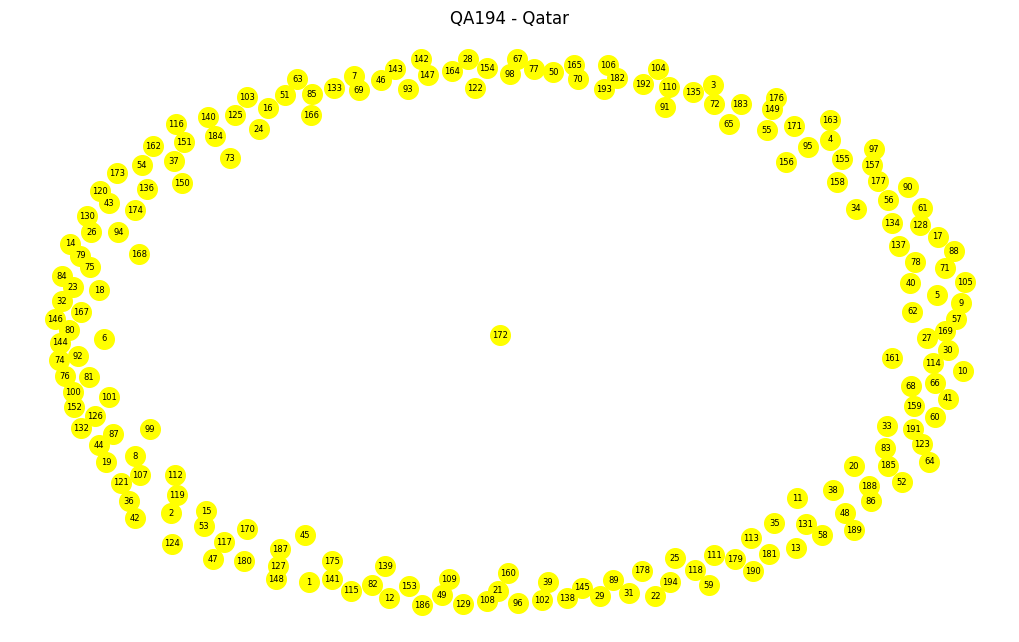

In [ ]:
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_size=200, node_color='yellow', font_size=6, font_color='black')
plt.title("QA194 - Qatar")
plt.show()


**Representación gráfica del grafo** creado previamente, donde los nodos se muestran como círculos amarillos con etiquetas y las aristas están representadas con líneas, y sus pesos se utilizan para ajustar el diseño del grafo si es necesario. La visualización es útil para inspeccionar y comprender mejor la estructura del grafo.

In [ ]:
num_nodes = len(G.nodes)
distances = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            x1, y1 = G.nodes[list(G.nodes)[i]]['pos']
            x2, y2 = G.nodes[list(G.nodes)[j]]['pos']
            euclidean_distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            distances[i][j] = euclidean_distance

Se efectuan las distancias euclidianas entre todos los pares de nodos en un grafo representado por G. Utiliza las coordenadas (x, y) asociadas a cada nodo para calcular la distancia euclidiana entre ellos, almacenando estas distancias en una matriz distances. Esta matriz es esencial para abordar problemas que involucran la optimización de rutas o distancias en el grafo, ya que proporciona información detallada sobre la distancia entre cada par de nodos, lo que es fundamental para tomar decisiones de rutas óptimas o resolver problemas de optimización relacionados con el grafo.

$p_{ij} = \frac{(\tau_{ij})^\alpha \cdot (\eta_{ij})^\beta}{\sum_{k \text{ sin visitar}}(\tau_{ik})^\alpha \cdot (\eta_{ik})^\beta}$

In [ ]:
def configuraciones_simulacion(opcion):
    num_ants = 10
    num_iterations = 100

    if opcion == 1:
        alpha = 1.0
        beta = 2.0
        rho = 0.1
    elif opcion == 2:
        alpha = 1.0
        beta = 4.0
        rho = 0.1
    elif opcion == 3:
        alpha = 1.0
        beta = 2.0
        rho = 0.9
    else:
        print("Opción no válida")
        return

    num_nodes = len(distances)
    pheromone_matrix = np.ones((num_nodes, num_nodes))

    def calculate_probabilities(current_node, unvisited_nodes, alpha, beta, pheromone_matrix, distances):
        probabilities = []
        total_prob = 0
        for node in unvisited_nodes:
            pheromone = pheromone_matrix[current_node][node]
            distance = distances[current_node][node]
            probability = (pheromone ** alpha) * ((1.0 / distance) ** beta)
            probabilities.append((node, probability))
            total_prob += probability
        probabilities = [(node, prob / total_prob) for node, prob in probabilities]
        return probabilities

    def build_tour(pheromone_matrix, distances, alpha, beta):
        unvisited_nodes = list(range(num_nodes))
        current_node = random.choice(unvisited_nodes)
        unvisited_nodes.remove(current_node)
        tour = [current_node]

        while unvisited_nodes:
            probabilities = calculate_probabilities(current_node, unvisited_nodes, alpha, beta, pheromone_matrix, distances)
            next_node = random.choices(population=[node for node, _ in probabilities], weights=[prob for _, prob in probabilities])[0]
            tour.append(next_node)
            current_node = next_node
            unvisited_nodes.remove(current_node)

        return tour

    def evaluate_tour(tour, distances):
        total_distance = 0
        for i in range(len(tour) - 1):
            total_distance += distances[tour[i]][tour[i + 1]]
        total_distance += distances[tour[-1]][tour[0]]
        return total_distance

    best_tour = None
    best_tour_length = float('inf')

    for iteration in range(num_iterations):
        ant_tours = [build_tour(pheromone_matrix, distances, alpha, beta) for _ in range(num_ants)]

        for ant_tour in ant_tours:
            tour_length = evaluate_tour(ant_tour, distances)
            if tour_length < best_tour_length:
                best_tour_length = tour_length
                best_tour = ant_tour

        for i in range(len(pheromone_matrix)):
            for j in range(len(pheromone_matrix[i])):
                pheromone_matrix[i][j] = (1 - rho) * pheromone_matrix[i][j]

        for i in range(len(best_tour) - 1):
            pheromone_matrix[best_tour[i]][best_tour[i + 1]] += 1.0 / best_tour_length
            pheromone_matrix[best_tour[i + 1]][best_tour[i]] += 1.0 / best_tour_length


    G = nx.Graph()
    for i in range(len(best_tour) - 1):
        G.add_edge(best_tour[i], best_tour[i + 1])
    G.add_edge(best_tour[-1], best_tour[0])
    plt.figure(figsize=(15, 10))
    plt.title(f"Optimal tour for the qa194 TSP instance. It has length equal to {best_tour_length}")
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='yellow', edge_color='black', with_labels=True)
    plt.show()



Se define una función que realiza una simulación de colonia de hormigas para resolver el Problema del Viajante (TSP) en una instancia específica. Se configuran parámetros clave, como el número de hormigas y la cantidad de iteraciones, así como factores de influencia en la elección de rutas. Luego, la simulación se ejecuta, generando recorridos para las hormigas y actualizando las feromonas en función de la calidad de los recorridos. Finalmente, se visualiza el recorrido óptimo encontrado en un gráfico que muestra el grafo del recorrido y el camino óptimo en amarillo, lo que permite identificar la solución al problema TSP para la instancia específica. Las configuraciones y parámetros influyen en la calidad de la solución encontrada por la simulación.

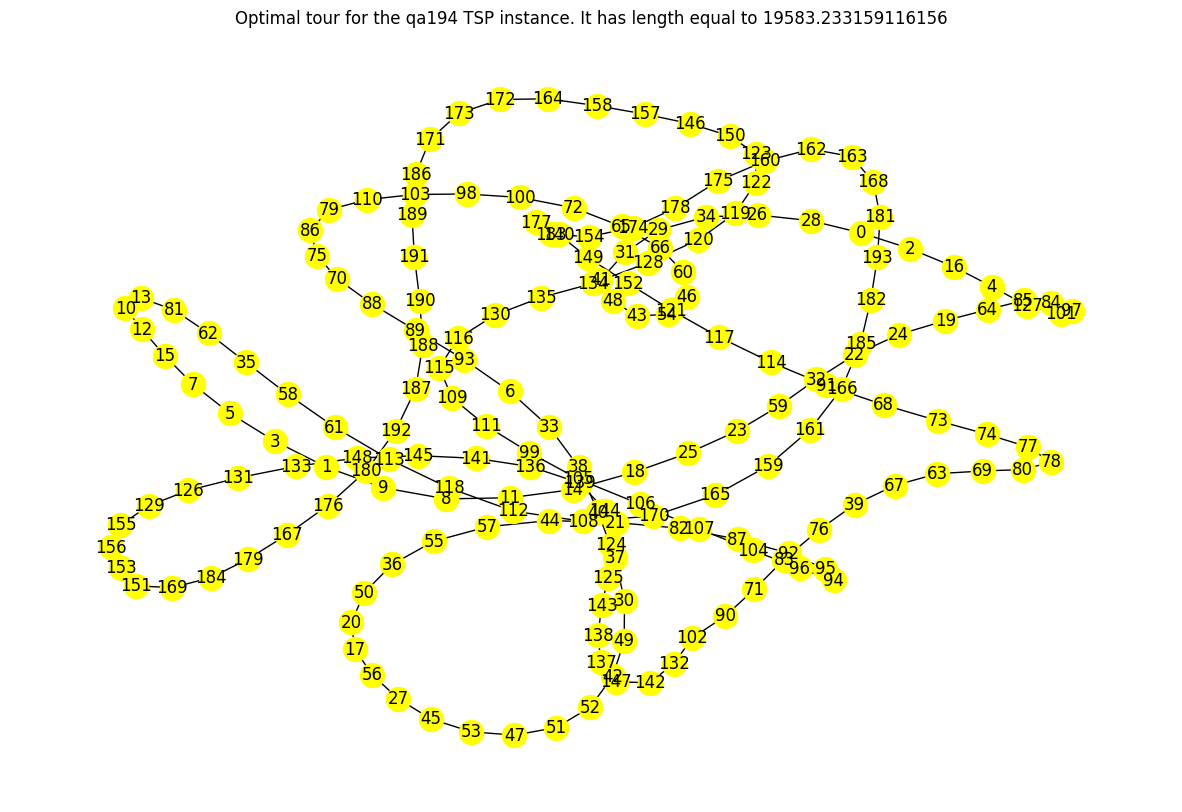

In [ ]:
configuraciones_simulacion(1)

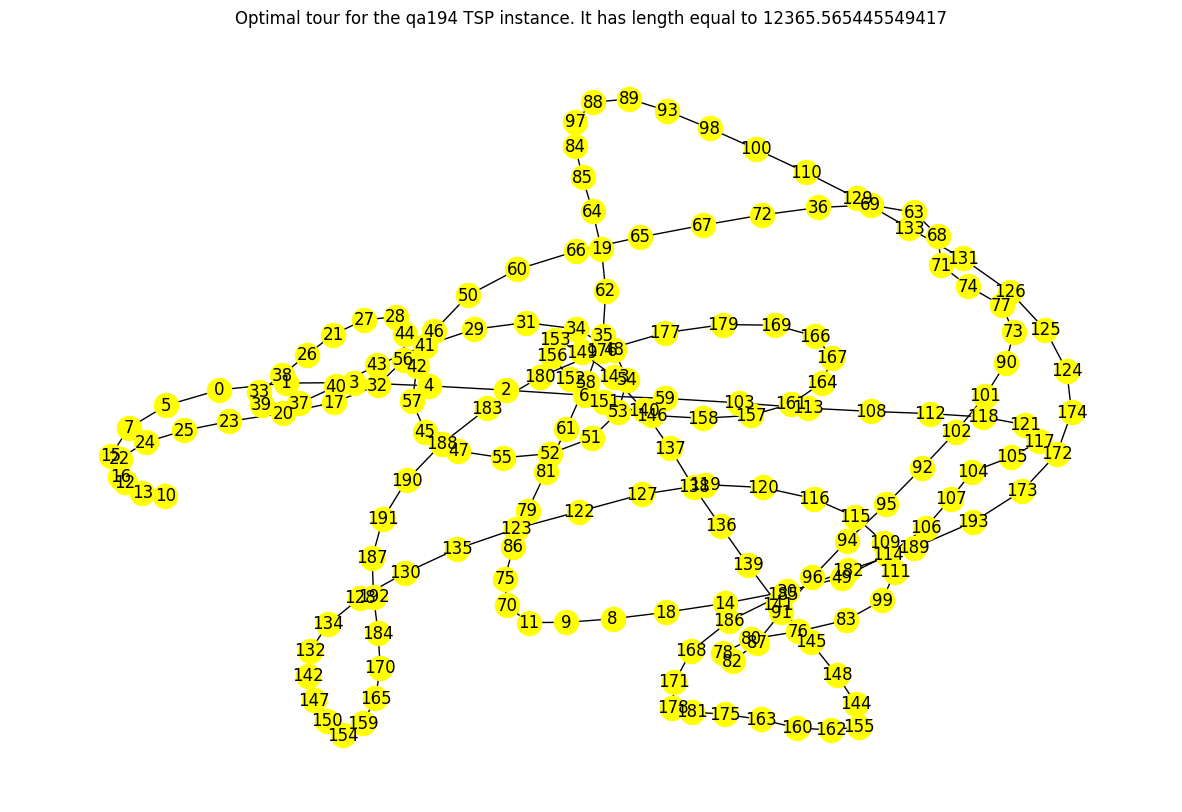

In [ ]:
configuraciones_simulacion(2)

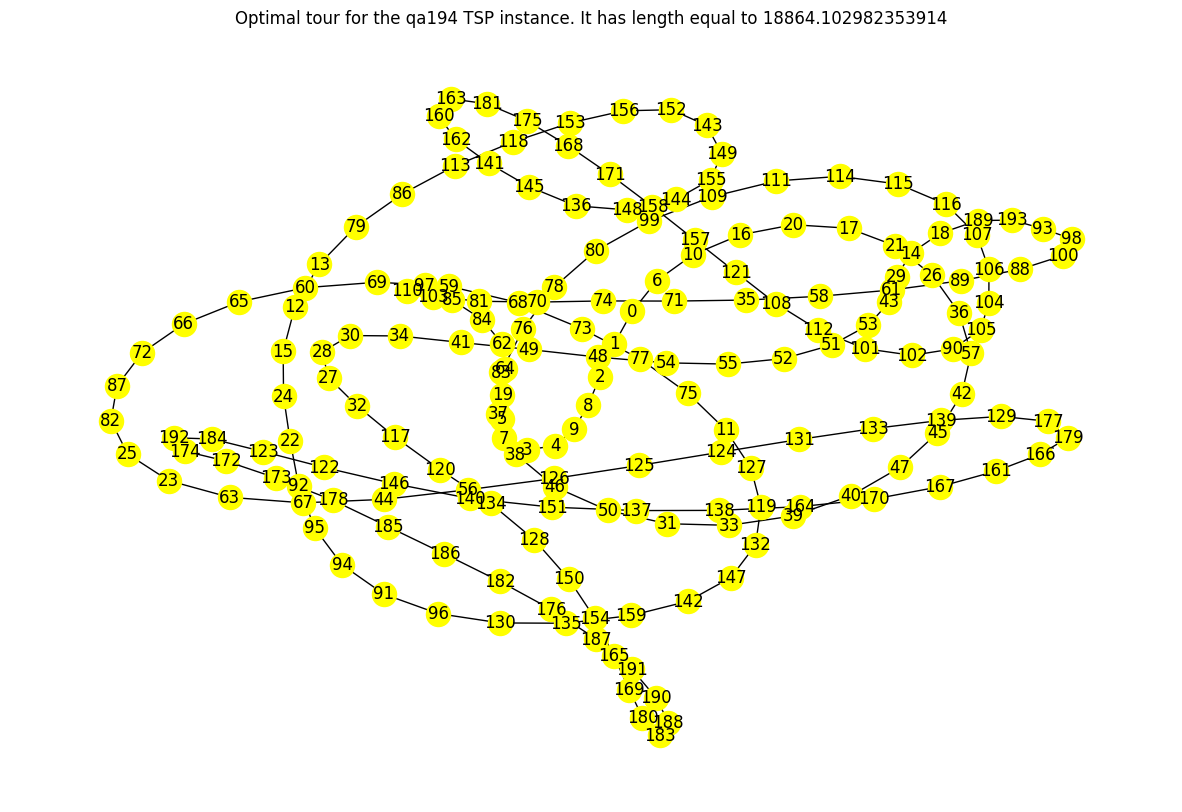

In [ ]:
configuraciones_simulacion(3)

**Dentro del resultado del código**, una comparación clave se encuentra en la evaluación de los recorridos generados por las hormigas. En cada iteración, se calcula la longitud del recorrido de cada hormiga y se compara con la longitud del mejor recorrido encontrado hasta el momento (best_tour_length). Si la longitud del recorrido de una hormiga es menor que la longitud del mejor recorrido conocido, se actualiza el recorrido óptimo y su longitud. Esta comparación permite a la simulación mejorar continuamente el recorrido más corto a medida que avanza en las iteraciones, lo que conduce a la identificación de la solución óptima o una solución de calidad en el Problema del Viajante (TSP). La actualización de feromonas también se basa en esta comparación para influir en la elección de rutas de las hormigas.

#**REFERENCIAS**

TSP tour of 194 populated locations in Qatar. (s. f.). Uwaterloo.ca. Recuperado 22 de octubre de 2023, de https://www.math.uwaterloo.ca/tsp/world/qatour.html

FICO Xpress Optimization Examples Repository: The travelling salesman problem. (s. f.). Fico.com. Recuperado 22 de octubre de 2023, de https://examples.xpress.fico.com/example.pl?id=TSP_python

Ant c. (s. f.). Scholarpedia.org. Recuperado 22 de octubre de 2023, de http://www.scholarpedia.org/article/Ant_c

